# DocDirect

## Component analysis

### Initialize

#### Imports & definitions

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from sklearn.decomposition import non_negative_factorization
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
! /usr/local/bin/sshfs -o IdentityFile=~/.ssh/bioinf_id_rsa -o volname=Home davelangers@bioinf.nl:/homes/davelangers /Volumes/Data/Bioinf/Home -p 4235

In [3]:
FILENAME = 'doc2wordbiza_cleaned.txt' # remote mount via /Volumes/Data/Bioinf/Home/doc2wordbiza_cleaned.txt
DOCUMENTS = 'docidmapping.txt'
DICTIONARY = 'OpenTaal_200G.txt'

#### Prepare data

<div class="alert alert-info">Note: last column from cleaned text file is converted to lower case and final periods are removed!</div>

In [4]:
docnames = pd.read_csv(DOCUMENTS,
                       sep='\t',
                       names=['doc', 'name'],
                       converters={'doc': lambda x: int(x[4:]),
                                   'name': lambda x: str(x)[:-4]
                                  },
                       index_col='doc'
                      )
docnames

,name
doc,
1,Archief_van_dhr._vd_Meijs_inzake_project_Payro...
2,Archief_van_dhr._vd_Meijs_inzake_project_Payro...
3,BSD-Handelingsnummer_143-118
4,BSD-Handelingsnummer_15-XV
5,FEZ_12893
...,...
265,Stukken_met_betrekking_Bureau_Dienstreizen_199...
266,VA-bestand_project_Beheer_Rijksbegroting_perio...
267,VA-bestand_project_Beheer_Rijksbegroting_perio...


In [5]:
corpus = pd.read_csv(FILENAME,
                     sep='\t',
                     names=['doc', 'line', 'word1', 'word2', 'word'],
                     usecols = ['doc','word'],
                     converters={'doc': lambda x: int(x[4:]),
                                 'word': lambda x: str(x).lower().rstrip('.')
                                }
                    )
corpus

,doc,word
0,1,archief
1,1,project
2,1,payroll
3,1,gearchiveerd
4,1,13
...,...,...
13212799,269,en
13212800,269,verloop
13212801,269,van
13212802,269,transacties


In [6]:
labels = docnames['name'].str.startswith('I') * 1  # "Inv.nr.*" documenten moeten wél bewaard
print('{:2.1f}% bewaren'.format(100.0 * labels.sum() / len(labels)))

81.0% bewaren


#### Count occurrences by words and by documents in a cross-table

<div class="alert alert-info">Note: Words that occur in less than 5 documents are omitted!</div>

In [7]:
table = pd.crosstab(corpus['word'], corpus['doc'])
table = table.loc[(table > 0).sum(axis=1) >= 5, :]
table.drop('', axis=0, inplace=True)

In [8]:
table

doc,1,2,3,4,5,6,7,8,9,10,...,260,261,262,263,264,265,266,267,268,269
word,,,,,,,,,,,,,,,,,,,,,
-,128,438,2,551,75,14,69,28,27,2,...,323,435,509,346,646,275,349,996,434,2
--,3,9,0,5,2,1,0,1,0,0,...,7,1,0,11,2,2,1,28,1,0
---,0,2,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,7,0,0
----,0,6,0,0,0,0,0,0,0,0,...,4,0,0,1,0,0,1,3,0,0
-----,1,14,0,0,0,0,0,0,0,0,...,1,0,1,0,1,1,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ê,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ï,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
óp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Document statistics

#### Accumulate occurences by document or by word separately

In [9]:
doccount = table.sum(axis=0)
docorder = np.argsort(doccount)[::-1]

wordcount = table.sum(axis=1)
wordorder = np.argsort(wordcount)[::-1]
table = table.iloc[wordorder, :]
wordcount = wordcount.iloc[wordorder]

#### Number of *total* occurrences of words by document

How long are documents?

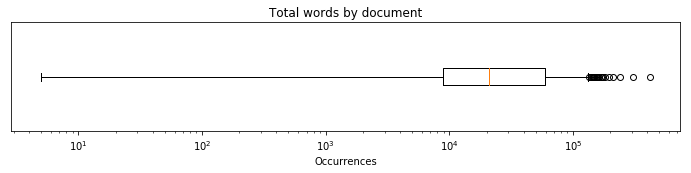

,count,mean,std,min,25%,50%,75%,max
Total words by document,269,44106,54286,5,8905,20972,59115,418684


In [10]:
plt.figure(figsize=(12, 2))
plt.boxplot(doccount.to_numpy(), vert=False)
plt.title('Total words by document'); plt.xlabel('Occurrences'); plt.xscale('log'); plt.yticks([])
plt.show()

pd.DataFrame(doccount.describe().astype(int), columns=['Total words by document']).transpose()

#### Number of *distinct* occurrences of words by document

How many different words in documents?

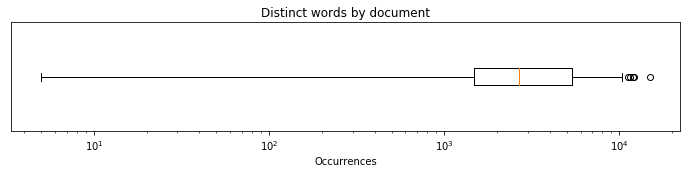

,count,mean,std,min,25%,50%,75%,max
Distinct words by document,269,3554,2748,5,1471,2683,5342,14914


In [11]:
plt.figure(figsize=(12, 2))
plt.boxplot((table > 0).sum(axis=0).to_numpy(), vert=False)
plt.title('Distinct words by document'); plt.xlabel('Occurrences'); plt.xscale('log'); plt.yticks([])
plt.show()

pd.DataFrame((table>0).sum(axis=0).describe().astype(int), columns=['Distinct words by document']).transpose()

#### Number of *total* occurrences of documents by word

How often do words occur in the entire corpus?

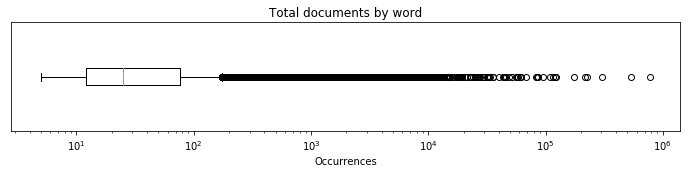

,count,mean,std,min,25%,50%,75%,max
Total documents by word,41323,287,5561,5,12,25,77,775962


In [12]:
plt.figure(figsize=(12, 2))
plt.boxplot(wordcount.to_numpy(), vert=False)
plt.title('Total documents by word'); plt.xlabel('Occurrences'); plt.xscale('log'); plt.yticks([])
plt.show()

pd.DataFrame(wordcount.describe().astype(int), columns=['Total documents by word']).transpose()

#### Number of *distinct* occurrences of documents by word

In how many documents do words occur?

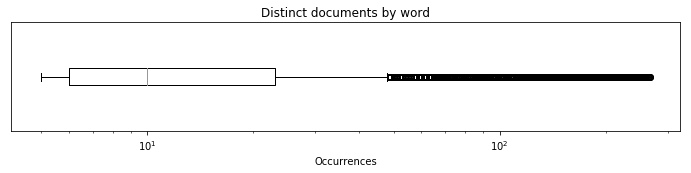

,count,mean,std,min,25%,50%,75%,max
Distinct documents by word,41323,23,33,5,6,10,23,267


In [13]:
plt.figure(figsize=(12, 2))
plt.boxplot((table > 0).sum(axis=1).to_numpy(), vert=False)
plt.title('Distinct documents by word'); plt.xlabel('Occurrences'); plt.xscale('log'); plt.yticks([])
plt.show()

pd.DataFrame((table>0).sum(axis=1).describe().astype(int), columns=['Distinct documents by word']).transpose()

### Miscellaneous statistics

#### Zipf's law

Compare word count distribution to [Zipf's law](https://www.wikiwand.com/en/Zipf%27s_law).

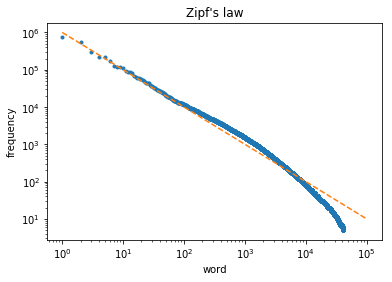

In [14]:
plt.loglog(np.arange(1, len(wordcount)+1), np.sort(wordcount.to_numpy())[::-1], '.')
plt.plot([1, 1e5], [1e6, 1e1], '--')
plt.title('Zipf\'s law'); plt.xlabel('word'); plt.ylabel('frequency')
plt.show()

#### Word lengths

Distribution of number of characters in distinct words.

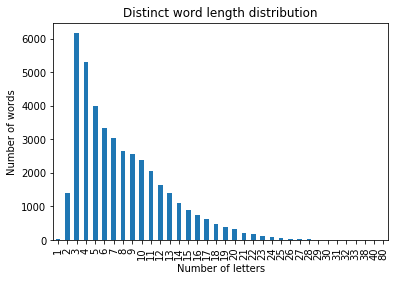

In [15]:
wordcount.index.map(len).value_counts().sort_index().plot(kind='bar')
plt.title('Distinct word length distribution'); plt.xlabel('Number of letters'); plt.ylabel('Number of words')
plt.show()

#### Alphanumeric word type distribution

Distinguish between alphabetic words consisting of letters a-z only, numeric words consisting of digits 0-9 and decimal characters, and all other words of mixed type or with other symbols.

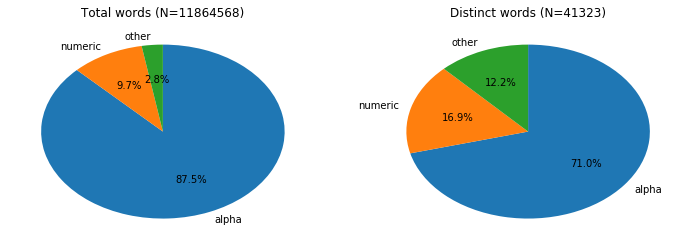

In [16]:
alpha = wordcount.index.str.match(r'^[a-z]*$')
numeric = wordcount.index.str.match(r'^[0-9,\.]*$')
other = ~alpha & ~numeric

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.pie([sum(wordcount[alpha]), sum(wordcount[numeric]), sum(wordcount[other])], autopct='%.1f%%', labels=['alpha', 'numeric', 'other'], startangle=90, counterclock=False)
plt.title(f'Total words (N={sum(wordcount)})')
plt.subplot(1, 2, 2)
plt.pie([sum(alpha), sum(numeric), sum(other)], autopct='%.1f%%', labels=['alpha', 'numeric', 'other'], startangle=90, counterclock=False)
plt.title(f'Distinct words (N={len(wordcount)})')
plt.show()

#### Rare word list

Show some of the rarest words that may be poorly OCR-ed.

In [17]:
dictionary = set(line.strip() for line in open(DICTIONARY, encoding='utf-8'))

print(', '.join(word for word in wordcount.index[~numeric][:-200:-1] if word not in dictionary))

hofman, ov-, dieni, 77-, tub, y_, unn, koaen, tme, senter, toc, w_, dhb, oun, ttu, totaal-, xx-, xxi, teii, y-j, y-v, bemst, 3.s, nng, uor, temming, ltl, 8-3, nljn, regellng, nlet-belastingontvangsten, inkoop-, 7oo, nno, kleuter-, lro, km-vergoeding, xss, ls-, gere-, 7an, 7ij, uoop, lsj, volumemutaties, reoht, vuqa, geva, zlf, x5, gettaire, bestedings-, organisatle-eenheid, xaa, secretaris-ge, x0, in.de, in.b.t, x.o, 6in, nzake, 7-0, vvat, wiw, defi, x-r, in-format, vvij, osl, oso, ttc, w.i, deo, oting, xit, vonnt, zkh, xjd, osj, xcl, vvu, rente-opbrengsten, nten, vwi, xia, nsr, delden, orj, nrt, orr, sectoroverstijgende, orri, renata, orv, lug, titia, .rv, .rr, .rf, intra-comptabel, paraar, .ot, .oor, vnor, uts, drs.p, maandverantw.belastingdienst, .sv, gelljk, .yj, dopr, .vs, .vo, .vn, tuu, teruq, .va, 8g, .tt, .ts, dov, .vc


### Determine word relevance using TF-IDF

#### Visualize fingerprints based on document-by-word counts

<div class="alert alert-info">Note: Analyses include all words, but only the 500 commonest words are shown!</div>

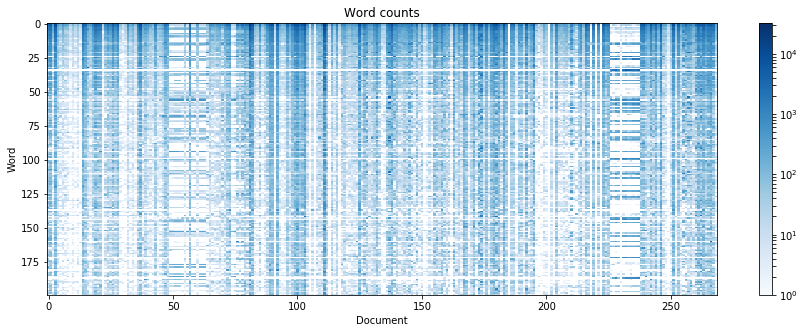

In [18]:
matrix = table.to_numpy()

plt.figure(figsize=(15, 5))
plt.imshow(matrix[:200, :], cmap=plt.get_cmap('Blues'), norm=LogNorm(vmin=1, vmax=matrix.max()))
plt.axis('tight'); plt.colorbar()
plt.title('Word counts'); plt.xlabel('Document'); plt.ylabel('Word')
plt.show()

#### Visualize fingerprints based on  TF-IDF

[Term Frequency - Inverse Document Frequency](https://www.wikiwand.com/en/Tf%E2%80%93idf) is defined as

$$
\text{TF-IDF} = \ln(1+f_{t,d}) \cdot \ln(\frac{N}{n_t})
$$

and is highest if a word occurs often in a particular document but at the same time occurs rarely in other documents.

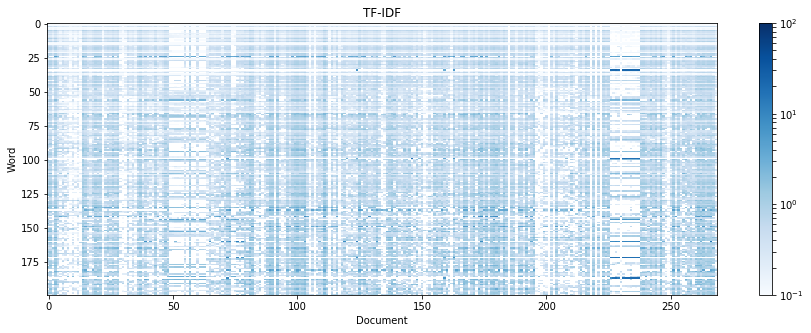

In [19]:
tf_idf = np.log(1.0 + matrix) * np.log(len(doccount) / np.sum(matrix > 0, axis=1, keepdims=True))

plt.figure(figsize=(15, 5))
plt.imshow(tf_idf[:200, :], cmap=plt.get_cmap('Blues'), norm=LogNorm(vmin=1e-1, vmax=1e2))
plt.axis('tight'); plt.colorbar()
plt.title('TF-IDF'); plt.xlabel('Document'); plt.ylabel('Word')
plt.show()

### Decomposition using NMF

[Non-negative matrix factorization](https://www.wikiwand.com/en/Non-negative_matrix_factorization) is comparable to PCA with constraints that components cannot contain negative numbers, and is related to [probabilistic latent semantic analysis](https://www.wikiwand.com/en/Probabilistic_latent_semantic_analysis).

#### Assess number of components

Construct a [Scree-plot](https://www.wikiwand.com/en/Scree_plot) explaining how much extra variance is explained by increasing the number of components.

According to the scree test, components to the left of the "elbow" of the graph should be retained as significant.

In [20]:
Nmax = 15

var_explained = []
oldvar = np.mean(tf_idf ** 2)
for comps in range(Nmax):
    W, H, n_iter = non_negative_factorization(tf_idf, n_components=comps+1, init='random', random_state=0)
    approx = W @ H
    newvar = np.mean((tf_idf - approx) ** 2)
    var_explained.append(oldvar - newvar)
    oldvar = newvar

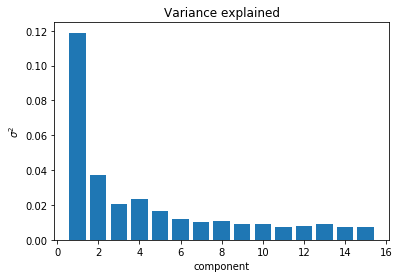

In [21]:
plt.bar(np.arange(Nmax) + 1, var_explained)
plt.xlabel('component'); plt.ylabel('$\sigma^2$'); plt.title('Variance explained')
plt.show()

#### Decompose into components

Using NMF, $N = 5$ components are extracted, and each document is assigned to a component based on its highest correlation with the component's TF-IDF scores.

In [22]:
Ncomps = 5
W, H, n_iter = non_negative_factorization(tf_idf, n_components=Ncomps, init='random', random_state=0)
comps = np.argmax(np.corrcoef(W, tf_idf, rowvar=False)[:Ncomps, Ncomps:], axis=0)

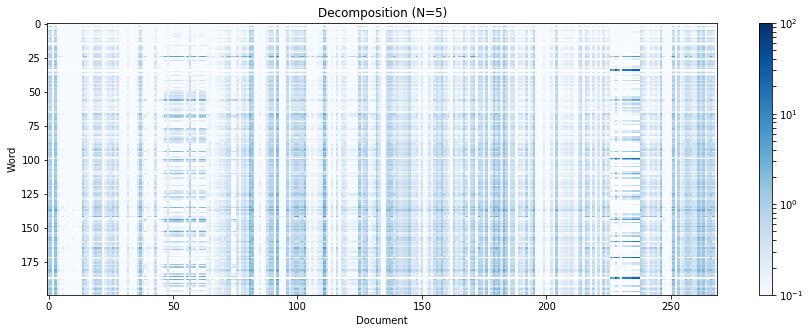

In [23]:
decomposition = np.empty_like(tf_idf)
for c in range(Ncomps):
    w = W[:, c:c+1]
    decomposition[:, comps == c] = w @ (w.T @ tf_idf[:, comps == c]) / (w.T @ w)

plt.figure(figsize=(15, 5))
plt.imshow(decomposition[:200, :], cmap=plt.get_cmap('Blues'), norm=LogNorm(vmin=1e-1, vmax=1e2))
plt.axis('tight'); plt.colorbar()
plt.title(f'Decomposition (N={Ncomps})'); plt.xlabel('Document'); plt.ylabel('Word')
plt.show()

#### Describe components

For each component, the top-20 relevant words and the documents belonging to that component including the distribution of labels are listed.

In [24]:
for c in range(Ncomps):
    print(f'COMPONENT #{c+1}:'.center(80, '-'))
    print('Top-20 words:')
    print(', '.join(wordcount.index[np.argsort(W[:, c])[:-21:-1]]))
    print('Documents:')
    print(', '.join(str(i) for i in doccount.index[comps == c]))
    print('Labeling:')
    print('{:2.1f}% bewaren'.format(100.0 * labels[comps == c].sum() / len(labels[comps == c])))
print('-' * 80)

---------------------------------COMPONENT #1:----------------------------------
Top-20 words:
onderafdeling, investeringsbank, kredietverlening, 1979, staatsmuntbedrijf, 000, ontwikkelingslanden, 1981, ems, 1978, 1980, kapitaaluitgaven, memorie, stb, aanslagregeling, 1976, wetsontwerp, rijksinkoopbureau, ontwikkelingsbanken, kapitaal
Documents:
6, 16, 49, 56, 61, 65, 67, 71, 73, 74, 77, 78, 79, 80, 81, 82, 88, 90, 91, 93, 99, 102, 103, 105, 106, 107, 108, 109, 110, 111, 113, 116, 119, 122, 123, 124, 125, 127, 128, 131, 135, 136, 140, 149, 156, 160, 162, 163, 164, 166, 167, 168, 171, 172, 173, 178, 251, 252, 257, 259, 267
Labeling:
93.4% bewaren
---------------------------------COMPONENT #2:----------------------------------
Top-20 words:
cafa, cafa-bureau, cafa-1, rcc, functionaliteit, prototype, functioneel, cafa-i, odb, mimer, programmatuur, budgethouder, budgethouders, administraties, afdrukken, systemen, fas, cap, gebruikers, functionele
Documents:
1, 2, 4, 5, 8, 10, 11, 12, 13, 1

### Classification

Define input and output data, using only the $N$ most relevant words based on TF-IDF scores.

In [25]:
N = 100
bestwords = np.argsort(tf_idf.sum(axis=1))[::-1]
X = tf_idf[bestwords[:N], :].T
Y = labels.values

#### Gaussian Naive Bayes

Based on real-valued scores, i.e.: what are the TF-IDFs of words in a document.

In [26]:
def classifier():
    return GaussianNB()

Resubstitution

              precision    recall  f1-score   support

           0       0.29      0.98      0.45        51
           1       0.99      0.44      0.61       218

    accuracy                           0.54       269
   macro avg       0.64      0.71      0.53       269
weighted avg       0.86      0.54      0.58       269



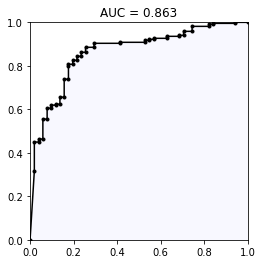

,0,1
0,50,1
1,122,96


In [27]:
model = classifier()
model.fit(X, Y)
P = model.predict_proba(X)[:, 1]

print(classification_report(Y, P > 0.5))

fpr, tpr, _ = roc_curve(Y, P)

fpr, tpr, _ = roc_curve(Y, P)
plt.fill_between(fpr, tpr, color='ghostwhite')
plt.plot(fpr, tpr, '.-k')
plt.axis('square'); plt.axis([0, 1, 0, 1])
plt.title(f'AUC = {auc(fpr, tpr):1.3f}')
plt.show()

pd.DataFrame(confusion_matrix(Y, P > 0.5))

LOO-crossvalidation

              precision    recall  f1-score   support

           0       0.27      0.90      0.42        51
           1       0.95      0.43      0.59       218

    accuracy                           0.52       269
   macro avg       0.61      0.67      0.50       269
weighted avg       0.82      0.52      0.56       269



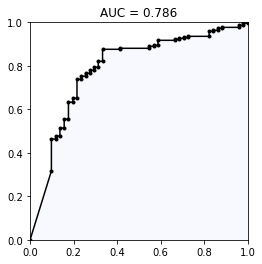

,0,1
0,46,5
1,124,94


In [28]:
for train, test in LeaveOneOut().split(X):
    model = classifier()
    model.fit(X[train], Y[train])
    P[test] = model.predict_proba(X[test])[:, 1]

print(classification_report(Y, P > 0.5))

fpr, tpr, _ = roc_curve(Y, P)
plt.fill_between(fpr, tpr, color='ghostwhite')
plt.plot(fpr, tpr, '.-k')
plt.axis('square'); plt.axis([0, 1, 0, 1])
plt.title(f'AUC = {auc(fpr, tpr):1.3f}')
plt.show()

pd.DataFrame(confusion_matrix(Y, P > 0.5))

#### Bernoulli Naive Bayes

Based on dichotomous scores, i.e.: what words occur in a document.

In [29]:
def classifier():
    return BernoulliNB(binarize=1e-6)

Resubstitution

              precision    recall  f1-score   support

           0       0.49      0.71      0.58        51
           1       0.92      0.83      0.87       218

    accuracy                           0.80       269
   macro avg       0.70      0.77      0.72       269
weighted avg       0.84      0.80      0.82       269



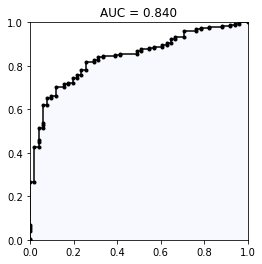

,0,1
0,36,15
1,38,180


In [30]:
model = classifier()
model.fit(X, Y)
P = model.predict_proba(X)[:, 1]

print(classification_report(Y, P > 0.5))

fpr, tpr, _ = roc_curve(Y, P)

fpr, tpr, _ = roc_curve(Y, P)
plt.fill_between(fpr, tpr, color='ghostwhite')
plt.plot(fpr, tpr, '.-k')
plt.axis('square'); plt.axis([0, 1, 0, 1])
plt.title(f'AUC = {auc(fpr, tpr):1.3f}')
plt.show()

pd.DataFrame(confusion_matrix(Y, P > 0.5))

LOO-crossvalidation

              precision    recall  f1-score   support

           0       0.43      0.61      0.50        51
           1       0.90      0.81      0.85       218

    accuracy                           0.77       269
   macro avg       0.66      0.71      0.68       269
weighted avg       0.81      0.77      0.79       269



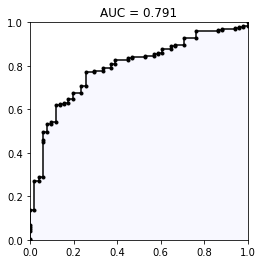

,0,1
0,31,20
1,41,177


In [31]:
for train, test in LeaveOneOut().split(X):
    model = classifier()
    model.fit(X[train], Y[train])
    P[test] = model.predict_proba(X[test])[:, 1]

print(classification_report(Y, P > 0.5))

fpr, tpr, _ = roc_curve(Y, P)
plt.fill_between(fpr, tpr, color='ghostwhite')
plt.plot(fpr, tpr, '.-k')
plt.axis('square'); plt.axis([0, 1, 0, 1])
plt.title(f'AUC = {auc(fpr, tpr):1.3f}')
plt.show()

pd.DataFrame(confusion_matrix(Y, P > 0.5))

***

©2021 - [Dave R.M. Langers](d.r.m.langers@pl.hanze.nl)